<a href="https://colab.research.google.com/github/ramajoballester/mil_deeplearning/blob/main/1_Introduccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sesión 1. Introducción al Deep Learning

# Introducción

En solo los últimos cinco años, el Aprendizaje Profundo (*Deep Learning*) ha impulsado un rápido progreso en campos tan diversos como la visión por ordenador, el procesamiento del lenguaje natural, el reconocimiento automático del habla, el aprendizaje por refuerzo y la informática biomédica. Además, el éxito del aprendizaje profundo en tantas tareas de interés ha catalizado incluso desarrollos en el aprendizaje automático teórico y la estadística. Con estos avances en la mano, ahora podemos construir coches que se conducen solos con más autonomía que nunca (y menos autonomía de lo que algunas empresas podrían hacer creer), sistemas de respuesta inteligente que redactan automáticamente los correos electrónicos más mundanos y máquinas que dominan a los mejores humanos del mundo en juegos de mesa como el Go, una hazaña que antes se creía que estaba a décadas de distancia. Estas herramientas ya ejercen un impacto cada vez mayor en la industria y la sociedad, cambiando la forma de hacer películas, diagnosticar enfermedades y desempeñando un papel cada vez más importante en las ciencias básicas, desde la astrofísica hasta la biología.

## Instalación de librerías (quitar?)

In [145]:
! pip install -q wandb
! pip install -q --upgrade albumentations
! pip install -q ipympl

     |████████████████████████████████| 102 kB 5.8 MB/s 
     |████████████████████████████████| 47.8 MB 1.4 MB/s 


In [ ]:
!pip install --upgrade -q gspread

In [1]:
import gspread
import pandas as pd
from google.colab import auth
auth.authenticate_user()
from google.auth import default

In [2]:
creds, _ = default()
gc = gspread.authorize(creds)

In [3]:
url = 'https://docs.google.com/spreadsheets/d/1rDJQgihE4bvVNGmPjT8sH5mCRrbOfNcEFf8KZoxZ870/edit?usp=sharing'
worksheet = gc.open_by_url(url)

In [ ]:
a = float(worksheet.sheet1.get('C5')[0][0])

In [ ]:
a

0.954782

In [ ]:
row = 5
col = 3
value = 0.954782
worksheet.sheet1.update_cell(row, col, value);

# Regresión lineal

La regresión lineal es un modelo matemático que aproxima la relación entre una o más variables independientes y una variable dependiente. En las ciencias naturales y sociales, el objetivo de la regresión suele ser caracterizar la relación entre las entradas y las salidas. El aprendizaje automático, en cambio, se ocupa más a menudo de la predicción.

Los problemas de regresión surgen siempre que queremos predecir un valor numérico. Algunos ejemplos comunes son la predicción de precios (de viviendas, acciones, etc.), la predicción de la duración de la estancia (para los pacientes en el hospital), la previsión de la demanda (para las ventas al por menor), entre otros innumerables. No todos los problemas de predicción son problemas clásicos de regresión. En los problemas de clasificación, por ejemplo, el objetivo es predecir la pertenencia a un conjunto de categorías.

Más sobre teoría detrás de reg. lineal?

In [143]:
import random
import torch
# %matplotlib notebook
import matplotlib.pyplot as plt

from matplotlib.colors import hsv_to_rgb

In [28]:
def synthetic_data(w, b, noise, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, noise, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2.0])
true_b = 4.2
noise = 0.5
features, labels = synthetic_data(true_w, true_b, noise, 1000)

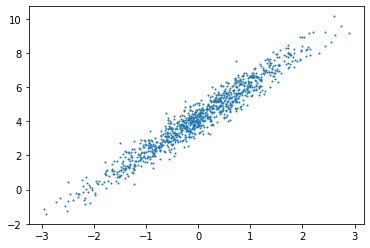

In [29]:
plt.scatter(features[:, 0], labels, 1);

In [30]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [31]:
batch_size = 8

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5878],
        [ 0.7563],
        [-0.7238],
        [-0.8571],
        [ 1.7229],
        [ 0.3907],
        [-0.9360],
        [ 0.4381]]) 
 tensor([[3.5591],
        [5.6308],
        [3.1466],
        [2.5750],
        [7.4162],
        [5.1642],
        [2.5212],
        [4.5701]])


In [32]:
def linreg(X, w, b):
    """Modelo de regresión lineal"""
    return torch.matmul(X, w) + b

In [33]:
def squared_loss(y_hat, y):
    """Función de pérdida Squared Loss"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [34]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [158]:
w = torch.normal(0, 0.01, size=(len(true_w),1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.01
num_epochs = 5
net = linreg
loss = squared_loss

w_vector = [w.item()]
b_vector = [b.item()]

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    
    w_vector.append(w.item())
    b_vector.append(b.item())

epoch 1, loss 0.986895
epoch 2, loss 0.188370
epoch 3, loss 0.125679
epoch 4, loss 0.119911
epoch 5, loss 0.119269


In [159]:
print('Error de estimación w: {}'.format(true_w - w.reshape(true_w.shape)))
print('Error de estimación b: {}'.format(true_b - b))

Error de estimación w: tensor([0.0246], grad_fn=<SubBackward0>)
Error de estimación b: tensor([0.0022], grad_fn=<RsubBackward1>)


In [160]:
print(w)
print(true_w)

tensor([[1.9754]], requires_grad=True)
tensor([2.])


In [161]:
torch.Tensor([[4], [5]]).shape

torch.Size([2, 1])

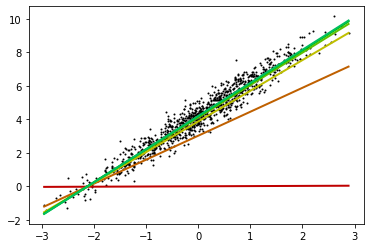

In [163]:
x1 = min(features[:, 0])
x2 = max(features[:, 0])
fig = plt.figure()
plt.scatter(features[:, 0], labels, 1, color='k');
for i in range(len(w_vector)):
    y1, y2 = (w_vector[i] * torch.Tensor([[x1], [x2]]) + b_vector[i]).detach().numpy()
    plt.plot([x1, x2], [y1, y2], color=hsv_to_rgb((0.5*(i/len(w_vector)), 1, 0.75)), linewidth=2);

## Read CSV

In [4]:
import pandas as pd

In [7]:
df_train = pd.read_csv('/content/sample_data/california_housing_train.csv')